In [2]:
import os
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import Input, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, Flatten, MaxPooling2D, Dropout
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
df = pd.read_csv('../data/fer2013.csv')

Mounted at /gdrive


#### **DATA PREPROCESSING**

In [4]:
df['pixels'] = df['pixels'].progress_apply(lambda x: np.asarray(list(map(float, x.split()))).reshape((48,48,1))/255.0)

  0%|          | 0/35887 [00:00<?, ?it/s]

In [5]:
emotion_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [6]:
def plot_image(x, label):
    title = emotion_dict[label]
    x = np.array(x).reshape((48,48))
    plt.imshow(x)
    plt.title(title)
    plt.axis('off')


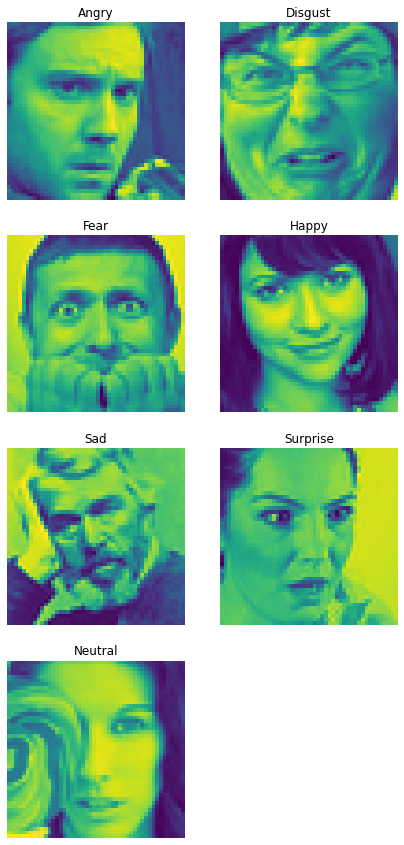

In [7]:
i = 0
j = 0

fig = plt.figure(figsize=(7, 15))
rows = 4
columns = 2


while(i<7):
    if(i == df['emotion'][j]):
        fig.add_subplot(rows, columns, i+1)
        plot_image(df['pixels'][j], df['emotion'][j])
        i+= 1
    j+=1
plt.show()

In [8]:
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

In [9]:
len(df_train), len(df_valid), len(df_test)

(28709, 3589, 3589)

In [11]:
x_train, y_train = np.array(df_train['pixels']), np.array(df_train['emotion'])
x_valid, y_valid = np.array(df_valid['pixels']), np.array(df_valid['emotion'])
x_test, y_test = np.array(df_test['pixels']), np.array(df_test['emotion'])

In [10]:
df_train = df_train[['pixels', 'emotion']]
df_valid = df_valid[['pixels', 'emotion']]
df_test = df_test[['pixels', 'emotion']]

In [18]:
x_train = np.array([np.array(i) for i in x_train])
x_valid = np.array([np.array(i) for i in x_valid])
x_test = np.array([np.array(i) for i in x_test])

In [40]:
def my_model():
    inputs = Input(shape = (48, 48, 1))
    x = Conv2D(128, 3)(inputs)
    x = BatchNormalization()(x)
    x = relu(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, 5, padding='same', kernel_regularizer=l2(0.02))(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(512, 3, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Conv2D(1024, 5, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Dropout(0.5)(x)
    x = Conv2D(2028, 5, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(7)(x)
    model = Model(inputs = inputs, outputs = outputs)
    return model
    

In [41]:
model = my_model()

In [42]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization_22 (Bat  (None, 46, 46, 128)      512       
 chNormalization)                                                
                                                                 
 tf.nn.relu_21 (TFOpLambda)  (None, 46, 46, 128)       0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 23, 23, 128)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 23, 23, 128)       0   

In [43]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer= Adam(learning_rate= 1e-5), metrics=['accuracy'])

In [44]:
model.fit(x_train, y_train, batch_size= 64, epochs = 55, validation_data = (x_valid, y_valid))

Epoch 1/55
449/449 [==============================] - 89s 192ms/step - loss: 28.8652 - accuracy: 0.2077 - val_loss: 28.1949 - val_accuracy: 0.2499
Epoch 2/55
449/449 [==============================] - 86s 192ms/step - loss: 27.7579 - accuracy: 0.2353 - val_loss: 27.1327 - val_accuracy: 0.2655
Epoch 3/55
449/449 [==============================] - 86s 192ms/step - loss: 26.6586 - accuracy: 0.2558 - val_loss: 26.0480 - val_accuracy: 0.2772
Epoch 4/55
449/449 [==============================] - 86s 192ms/step - loss: 25.4969 - accuracy: 0.2735 - val_loss: 24.8858 - val_accuracy: 0.2934
Epoch 5/55
449/449 [==============================] - 86s 192ms/step - loss: 24.2959 - accuracy: 0.3038 - val_loss: 23.6882 - val_accuracy: 0.3293
Epoch 6/55
449/449 [==============================] - 86s 192ms/step - loss: 23.0750 - accuracy: 0.3194 - val_loss: 22.4634 - val_accuracy: 0.3402
Epoch 7/55
449/449 [==============================] - 86s 192ms/step - loss: 21.8486 - accuracy: 0.3377 - val_loss: 21

In [45]:
model.fit(x_train, y_train, batch_size= 64, epochs = 15, validation_data = (x_valid, y_valid))

Epoch 1/15
449/449 [==============================] - 86s 191ms/step - loss: 2.2076 - accuracy: 0.7109 - val_loss: 2.5464 - val_accuracy: 0.6057
Epoch 2/15
449/449 [==============================] - 86s 191ms/step - loss: 2.1579 - accuracy: 0.7207 - val_loss: 2.5143 - val_accuracy: 0.6027
Epoch 3/15
449/449 [==============================] - 86s 192ms/step - loss: 2.1049 - accuracy: 0.7262 - val_loss: 2.5579 - val_accuracy: 0.5821
Epoch 4/15
449/449 [==============================] - 86s 191ms/step - loss: 2.0676 - accuracy: 0.7297 - val_loss: 2.4711 - val_accuracy: 0.6024
Epoch 5/15
449/449 [==============================] - 86s 192ms/step - loss: 2.0238 - accuracy: 0.7376 - val_loss: 2.4608 - val_accuracy: 0.5982
Epoch 6/15
449/449 [==============================] - 86s 191ms/step - loss: 1.9798 - accuracy: 0.7421 - val_loss: 2.4465 - val_accuracy: 0.6030
Epoch 7/15
449/449 [==============================] - 86s 191ms/step - loss: 1.9367 - accuracy: 0.7522 - val_loss: 2.4214 - val_ac

In [47]:
model.fit(x_train, y_train, batch_size= 64, epochs = 15, validation_data = (x_valid, y_valid))

Epoch 1/15
449/449 [==============================] - 87s 193ms/step - loss: 1.6619 - accuracy: 0.7967 - val_loss: 2.3515 - val_accuracy: 0.6110
Epoch 2/15
449/449 [==============================] - 86s 192ms/step - loss: 1.6437 - accuracy: 0.8009 - val_loss: 2.2820 - val_accuracy: 0.6180
Epoch 3/15
449/449 [==============================] - 86s 192ms/step - loss: 1.6123 - accuracy: 0.8085 - val_loss: 2.3045 - val_accuracy: 0.6191
Epoch 4/15
449/449 [==============================] - 86s 192ms/step - loss: 1.5898 - accuracy: 0.8105 - val_loss: 2.3434 - val_accuracy: 0.6063
Epoch 5/15
449/449 [==============================] - 86s 191ms/step - loss: 1.5656 - accuracy: 0.8175 - val_loss: 2.3350 - val_accuracy: 0.6052
Epoch 6/15
449/449 [==============================] - 86s 191ms/step - loss: 1.5495 - accuracy: 0.8199 - val_loss: 2.3276 - val_accuracy: 0.6055
Epoch 7/15
449/449 [==============================] - 86s 191ms/step - loss: 1.5306 - accuracy: 0.8232 - val_loss: 2.3131 - val_ac

In [48]:
model.evaluate(x_test, y_test)

113/113 [==============================] - 5s 41ms/step - loss: 2.2029 - accuracy: 0.6305


[2.202859878540039, 0.630537748336792]

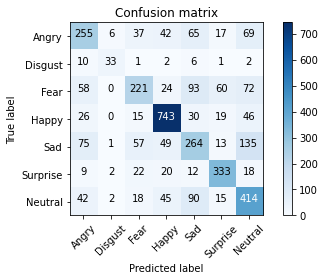

In [50]:
from sklearn.metrics import confusion_matrix
import itertools

y_pred = model.predict(x_test)
y_pred = [np.argmax(x) for x in y_pred]
cm = confusion_matrix(y_test, y_pred)
labels = emotion_dict.values()
title='Confusion matrix'
# print(cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [51]:
model.save('/gdrive/MyDrive/Emotion-Recognition/models/cnn')

INFO:tensorflow:Assets written to: /gdrive/MyDrive/Emotion-Recognition/models/cnn/assets
